# DDXPlus baseline (CausalBuilder evaluation)

使用 `DDXPlusCausalBuilder` 对 `01/DDXPlus_CausalQA.jsonl` 进行测试评估（流程参考 `01/wiqa_test_cdcr_evaluation_mistral.ipynb`）。

- 默认模型：`mistral:7b`（可用环境变量 `DDXPLUS_MODEL` 覆盖）
- 并行线程数：`DDXPLUS_MAX_WORKERS`（默认 4）


In [1]:
import os
import json
from pathlib import Path

import pandas as pd
from tqdm import tqdm

# Robust import whether notebook is opened from repo root or `01/`.
try:
    from DDXPlusCausalBuilder import DDXPlusCausalBuilder
except ModuleNotFoundError:
    import sys
    candidate = Path.cwd() / '01'
    sys.path.insert(0, str(candidate))
    from DDXPlusCausalBuilder import DDXPlusCausalBuilder


In [2]:
# Locate and load dataset
candidate_paths = [
    Path('DDXPlus_CausalQA_multistep_meta.jsonl'),
]
for p in candidate_paths:
    if p.exists():
        jsonl_path = p
        break
else:
    raise FileNotFoundError('Could not find DDXPlus_CausalQA.jsonl. Tried: ' + ', '.join(map(str, candidate_paths)))

records = []
with jsonl_path.open('r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        records.append(json.loads(line))

print(f'Dataset: {jsonl_path.resolve()}')
print(f'Total records: {len(records)}')
pd.Series([r.get('answer_label', '') for r in records]).value_counts(dropna=False)


Dataset: E:\PHD\01\DDXPlus_CausalQA_multistep_meta.jsonl
Total records: 200


less    100
more    100
Name: count, dtype: int64

In [3]:
# Store results
results = []

# You can limit samples for a quick smoke test
# records = records[:5]


In [4]:
# -----------------------------
# Multithread evaluation runner
# -----------------------------
from concurrent.futures import ThreadPoolExecutor, as_completed
import contextlib
import time

MODEL_NAME = os.environ.get('DDXPLUS_MODEL', 'llama3.1:8b')
try:
    MAX_WORKERS = int(os.environ.get('DDXPLUS_MAX_WORKERS', '4'))
except Exception:
    MAX_WORKERS = 4

# Set to False if you want to see per-question pipeline prints (not recommended in multi-thread).
SUPPRESS_PIPELINE_OUTPUT = True

class _NullWriter:
    def write(self, s):
        return len(s)
    def flush(self):
        pass

_NULL = _NullWriter()

def _process_record(record, idx: int):
    try:
        datapoint = {
            'question_stem': record.get('question_stem', ''),
            'answer_label': record.get('answer_label', ''),
            'answer_label_as_choice': record.get('answer_label_as_choice', ''),
            'choices': record.get('choices') or {
                'text': ['more', 'less', 'no effect'],
                'label': ['A', 'B', 'C'],
            },
        }

        builder = DDXPlusCausalBuilder(datapoint, model_name=MODEL_NAME)
        if SUPPRESS_PIPELINE_OUTPUT:
            with contextlib.redirect_stdout(_NULL), contextlib.redirect_stderr(_NULL):
                is_correct = builder.run_wiqa_pipeline()
        else:
            is_correct = builder.run_wiqa_pipeline()

        return {
            'index': idx,
            'question': datapoint.get('question_stem', ''),
            'gold_answer': datapoint.get('answer_label', ''),
            'gold_choice': datapoint.get('answer_label_as_choice', ''),
            'is_correct': bool(is_correct),
            'cause_event': getattr(builder, 'cause_event', ''),
            'outcome_base': getattr(builder, 'outcome_base', ''),
        }

    except Exception as e:
        return {
            'index': idx,
            'question': record.get('question_stem', ''),
            'gold_answer': record.get('answer_label', ''),
            'gold_choice': record.get('answer_label_as_choice', ''),
            'is_correct': False,
            'cause_event': '',
            'outcome_base': '',
            'error': str(e),
        }

results = [None] * len(records)
t0 = time.time()

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(_process_record, r, i): i for i, r in enumerate(records)}
    for fut in tqdm(as_completed(futures), total=len(futures), desc=f'Processing DDXPlus ({MAX_WORKERS} threads)'):
        idx = futures[fut]
        results[idx] = fut.result()

results = [r for r in results if r is not None]
elapsed = time.time() - t0
print(f'Processing complete! Total results: {len(results)} (elapsed={elapsed:.1f}s, workers={MAX_WORKERS}, model={MODEL_NAME})')


Processing complete! Total results: 200 (elapsed=8629.9s, workers=4, model=llama3.1:8b)


In [5]:
# Save results to JSON + CSV
output_dir = jsonl_path.parent
model_tag = MODEL_NAME.replace(':', '_').replace('/', '_')

output_json = output_dir / f'ddxplus_test_results_{model_tag}.json'
with output_json.open('w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)
print(f'Full results saved to: {output_json}')

results_df = pd.DataFrame(results)
output_csv = output_dir / f'ddxplus_test_results_{model_tag}.csv'
results_df.to_csv(output_csv, index=False, encoding='utf-8')
print(f'CSV results saved to: {output_csv}')


Full results saved to: ddxplus_test_results_llama3.1_8b.json
CSV results saved to: ddxplus_test_results_llama3.1_8b.csv


In [6]:
# Calculate overall statistics
total_count = len(results)
correct_count = sum(1 for r in results if r.get('is_correct'))
error_count = sum(1 for r in results if r.get('error'))
accuracy = correct_count / total_count if total_count > 0 else 0.0

print('=' * 80)
print('OVERALL STATISTICS')
print('=' * 80)
print(f'Total processed: {total_count}')
print(f'Correct: {correct_count}')
print(f'Wrong: {total_count - correct_count - error_count}')
print(f'Errors: {error_count}')
print(f'Accuracy: {accuracy:.2%}')


OVERALL STATISTICS
Total processed: 200
Correct: 134
Wrong: 66
Errors: 0
Accuracy: 67.00%


In [7]:
def _norm_label(x) -> str:
    return str(x or '').strip().lower().replace(' ', '_')

print('=' * 80)
print('STATISTICS BY GOLD ANSWER')
print('=' * 80)

for label in ['more', 'less', 'no_effect']:
    label_results = [r for r in results if _norm_label(r.get('gold_answer')) == label]
    if not label_results:
        continue

    label_total = len(label_results)
    label_correct = sum(1 for r in label_results if r.get('is_correct'))
    label_errors = sum(1 for r in label_results if r.get('error'))
    label_accuracy = label_correct / label_total if label_total > 0 else 0.0

    print(f"\n{label}:")
    print(f"  Total: {label_total}")
    print(f"  Correct: {label_correct}")
    print(f"  Wrong: {label_total - label_correct - label_errors}")
    print(f"  Errors: {label_errors}")
    print(f"  Accuracy: {label_accuracy:.2%}")


STATISTICS BY GOLD ANSWER

more:
  Total: 100
  Correct: 71
  Wrong: 29
  Errors: 0
  Accuracy: 71.00%

less:
  Total: 100
  Correct: 63
  Wrong: 37
  Errors: 0
  Accuracy: 63.00%


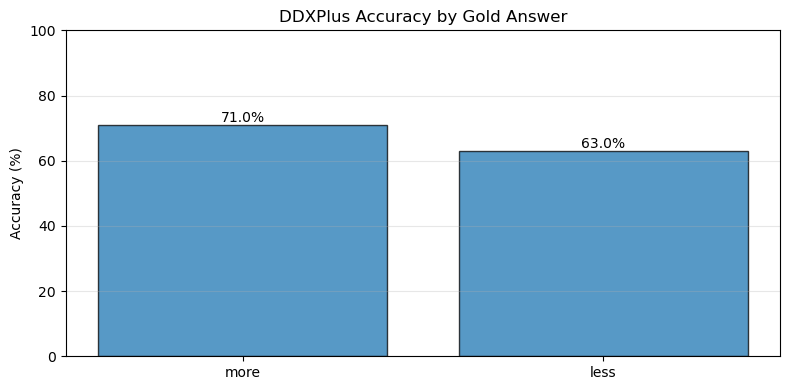

Plot saved to: ddxplus_accuracy_by_gold_llama3.1_8b.png


In [8]:
# Plot accuracy by gold label
import matplotlib.pyplot as plt

output_dir = jsonl_path.parent
model_tag = MODEL_NAME.replace(':', '_').replace('/', '_')

labels = ['more', 'less', 'no_effect']
stats = {}
for lab in labels:
    subset = [r for r in results if _norm_label(r.get('gold_answer')) == lab and not r.get('error')]
    if not subset:
        continue
    total = len(subset)
    correct = sum(1 for r in subset if r.get('is_correct'))
    stats[lab] = {
        'total': total,
        'correct': correct,
        'accuracy': (correct / total) if total else 0.0,
    }

types = list(stats.keys())
accuracies = [stats[t]['accuracy'] * 100 for t in types]

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(types, accuracies, alpha=0.75, edgecolor='black')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim(0, 100)
ax.set_title('DDXPlus Accuracy by Gold Answer')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plot_path = output_dir / f'ddxplus_accuracy_by_gold_{model_tag}.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'Plot saved to: {plot_path}')


In [9]:
# Quick error review (first 10)
print('=' * 80)
print('ERROR REVIEW (first 10)')
print('=' * 80)

errs = [r for r in results if r.get('error')]
for r in errs[:10]:
    print(f"\nIndex {r.get('index')}: {r.get('gold_answer')}")
    print(f"Question: {r.get('question')}")
    print(f"Error: {r.get('error')}")


ERROR REVIEW (first 10)


In [10]:
# Display a compact table
results_df[['index', 'gold_answer', 'gold_choice', 'is_correct']].head(20)


,index,gold_answer,gold_choice,is_correct
0,0,less,B,False
1,1,more,A,True
2,2,less,B,False
3,3,more,A,True
4,4,more,A,True
5,5,more,A,True
6,6,more,A,True
7,7,less,B,True
8,8,more,A,True
9,9,more,A,False
